## Mobile Country of Origin Classification

Sydney Bergen and Justin Jones

The goal of this project is to train data and predict a classifier for country of origin for mobile apps. We are using the dataset from nprint. The original intended purpose for this dataset was to "examine the privacy of the 100 most popular IOS and Android applications in India, China, and the US.

#### 1. Load Libraries

The first thing to be done is install netml and several other libraries for later usage.

In [4]:
from sklearn.model_selection import train_test_split
from netml.pparser.parser import PCAP
from netml.ndm.gmm import GMM
from netml.ndm.pca import PCA
from netml.ndm.model import MODEL
from netml.ndm.ocsvm import OCSVM
import numpy as np
from netml.ndm.kde import KDE
from netml.ndm.iforest import IF
from netml.ndm.gmm import GMM
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (8,6)

#### 2. Load Data

We took the original data from https://drive.google.com/file/d/1QRRY5gPPrZ9keOdDORmuGStVjFGapuMn/view?usp=sharing and noticed that it was not labelled with a column, but rather in the comments. Sorting the comments, we decided to separate the large pcapng file into 3 separate ones: china, india and us. We can use netml to convert the pcap files to flows.

In [13]:
RANDOM_STATE = 42

china = PCAP(
    'content/china.pcapng', ## you might need to upload the file again
    flow_ptks_thres=1,
    random_state=42,
    verbose=0,
)

india = PCAP(
    'content/india.pcapng', ## you might need to upload the file again
    flow_ptks_thres=1,
    random_state=42,
    verbose=0,
)

us = PCAP(
    'content/us.pcapng', ## you might need to upload the file again
    flow_ptks_thres=1,
    random_state=42,
    verbose=0,
)

In [14]:
china.pcap2flows()
india.pcap2flows()
us.pcap2flows()

'_pcap2flows()' starts at 2022-12-09 19:19:30
'_pcap2flows()' starts at 2022-12-09 19:19:30
'_pcap2flows()' ends at 2022-12-09 19:19:33 and takes 0.0513 mins.
'_pcap2flows()' starts at 2022-12-09 19:19:33
'_pcap2flows()' ends at 2022-12-09 19:19:33 and takes 0.0513 mins.
'_pcap2flows()' starts at 2022-12-09 19:19:33
'_pcap2flows()' ends at 2022-12-09 19:19:40 and takes 0.12 mins.
'_pcap2flows()' starts at 2022-12-09 19:19:40
'_pcap2flows()' ends at 2022-12-09 19:19:40 and takes 0.12 mins.
'_pcap2flows()' starts at 2022-12-09 19:19:40
'_pcap2flows()' ends at 2022-12-09 19:19:43 and takes 0.0549 mins.
'_pcap2flows()' ends at 2022-12-09 19:19:43 and takes 0.0549 mins.


#### 3. Feature Selection

With the flows, we can select and extract features. We used IAT to see different features, which present flows as timeseries of inter-arrival times between packets. At the end of this step, we make a label for each dataset and combine them. Additionally, we use the train_test_split function to create our training and testing datasets.

In [15]:
# label each flow 
china.label_flows(label=0)
india.label_flows(label=1)
us.label_flows(label=2)

'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.
'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.
'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.
'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.
'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.
'_label_flows()' starts at 2022-12-09 19:19:47
'_label_flows()' ends at 2022-12-09 19:19:47 and takes 0.0 mins.


In [16]:
## extract features
china.flow2features('IAT', fft=False, header=False)
india.flow2features('IAT', fft=False, header=False)
us.flow2features('IAT', fft=False, header=False)

'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0012 mins.
'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0005 mins.
'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0002 mins.
'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0012 mins.
'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0005 mins.
'_flow2features()' starts at 2022-12-09 19:19:51
'_flow2features()' ends at 2022-12-09 19:19:51 and takes 0.0002 mins.


In [17]:
(features_china, labels_china) = (china.features[:,:5], china.labels)
(features_india, labels_india) = (india.features[:,:5], india.labels)
(features_us, labels_us) = (us.features[:,:5], us.labels)

(features, labels) = (np.concatenate((features_china, features_india, features_us), axis=0) , 
                       np.concatenate((labels_china, labels_india, labels_us), axis=0))

In [18]:
# split train and test sets
(features_train,
    features_test,
    labels_train,
    labels_test,
) = train_test_split(features, labels, test_size=0.33, random_state=RANDOM_STATE)

#### 4. Model Selection and Training

With our datasets ready to be used, we can now create our models and test their accuracies in predicting our test dataset's labels.

##### Unsupervised Learning models

In [19]:
# create detection models
model1 = KDE(kernel='gaussian', bandwidth=1.0, random_state=RANDOM_STATE)
model2 = IF(n_estimators=100, random_state=RANDOM_STATE) ## model with best performance
model3 = PCA(n_components=1, random_state=RANDOM_STATE)
model4 = OCSVM(kernel='rbf', nu=0.5, random_state=RANDOM_STATE)
model5 = GMM(n_components=2, covariance_type='full', random_state=RANDOM_STATE)

model1.name = 'KDE'
model2.name = 'IF'
model3.name = 'PCA'
model4.name = 'OCSVM'
model5.name = 'GMM'

ndm1 = MODEL(model1, score_metric='auc', verbose=0, random_state=RANDOM_STATE)
ndm2 = MODEL(model2, score_metric='auc', verbose=0, random_state=RANDOM_STATE)
ndm3 = MODEL(model3, score_metric='auc', verbose=0, random_state=RANDOM_STATE)
ndm4 = MODEL(model4, score_metric='auc', verbose=0, random_state=RANDOM_STATE)
ndm5 = MODEL(model5, score_metric='auc', verbose=0, random_state=RANDOM_STATE)

# train the models from the train set
ndm1.train(features_train)
ndm2.train(features_train)
ndm3.train(features_train)
ndm4.train(features_train)
ndm5.train(features_train)

# evaluate the trained models
ndm1.test(features_test, labels_test)
ndm2.test(features_test, labels_test)
ndm3.test(features_test, labels_test)
ndm4.test(features_test, labels_test)
ndm5.test(features_test, labels_test)

'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:57 and takes 0.0002 mins.
'_train()' starts at 2022-12-09 19:19:57
'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:57 and takes 0.0002 mins.
'_train()' starts at 2022-12-09 19:19:57


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


'_train()' ends at 2022-12-09 19:19:57 and takes 0.0112 mins.
'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:57 and takes 0.0019 mins.
'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:58 and takes 0.001 mins.
'_train()' starts at 2022-12-09 19:19:58
'_train()' ends at 2022-12-09 19:19:57 and takes 0.0112 mins.
'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:57 and takes 0.0019 mins.
'_train()' starts at 2022-12-09 19:19:57
'_train()' ends at 2022-12-09 19:19:58 and takes 0.001 mins.
'_train()' starts at 2022-12-09 19:19:58
'_train()' ends at 2022-12-09 19:19:58 and takes 0.0071 mins.
'_test()' starts at 2022-12-09 19:19:58
'_test()' ends at 2022-12-09 19:19:58 and takes 0.0009 mins.
'_test()' starts at 2022-12-09 19:19:58
'_test()' ends at 2022-12-09 19:19:58 and takes 0.0015 mins.
'_test()' starts at 2022-12-09 19:19:58
'_test()' ends at 2022-12-09 19:19:58 and takes 0.0 mins.
'_test()' starts at 20

In [20]:
# model performances
print(ndm1.train.tot_time, ndm1.test.tot_time, ndm1.score)
print(ndm2.train.tot_time, ndm2.test.tot_time, ndm2.score)
print(ndm3.train.tot_time, ndm3.test.tot_time, ndm3.score)
print(ndm4.train.tot_time, ndm4.test.tot_time, ndm4.score)
print(ndm5.train.tot_time, ndm5.test.tot_time, ndm5.score)

0.0071 0.0 0.7122805795486208
0.0071 0.0 0.4059452493730844
0.0071 0.0 0.6816836166062971
0.0071 0.0 0.6516613262747283
0.0071 0.0 0.6077249930342714
0.0071 0.0 0.7122805795486208
0.0071 0.0 0.4059452493730844
0.0071 0.0 0.6816836166062971
0.0071 0.0 0.6516613262747283
0.0071 0.0 0.6077249930342714


##### Supervised Learning

Decision Tree

In [21]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(features_train, labels_train)

y_hat = clf.predict(features_test)

accuracy = accuracy_score(labels_test,  y_hat)

# print the predictions and the accuracy
print(accuracy)

0.7612244897959184
0.7612244897959184


In [22]:
print(classification_report(labels_test, y_hat))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       147
           1       0.73      0.76      0.74       194
           2       0.72      0.64      0.68       149

    accuracy                           0.76       490
   macro avg       0.76      0.76      0.76       490
weighted avg       0.76      0.76      0.76       490

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       147
           1       0.73      0.76      0.74       194
           2       0.72      0.64      0.68       149

    accuracy                           0.76       490
   macro avg       0.76      0.76      0.76       490
weighted avg       0.76      0.76      0.76       490



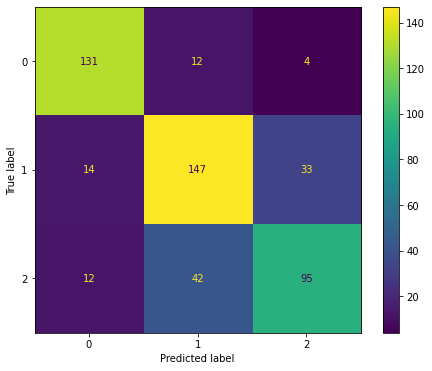

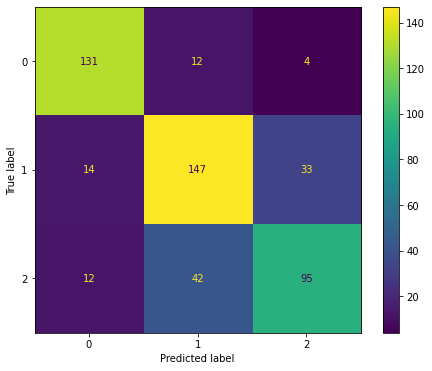

In [23]:
cm = confusion_matrix(labels_test, y_hat)

cm_display = ConfusionMatrixDisplay(cm).plot()

Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# train the classifier using the labeled points
rf.fit(features_train, labels_train)
y_hat = rf.predict(features_test)
accuracy = accuracy_score(labels_test,  y_hat)

print(accuracy)

0.7755102040816326
0.7755102040816326


In [25]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, y_hat))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       147
           1       0.73      0.78      0.75       194
           2       0.75      0.68      0.71       149

    accuracy                           0.78       490
   macro avg       0.78      0.78      0.78       490
weighted avg       0.78      0.78      0.77       490

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       147
           1       0.73      0.78      0.75       194
           2       0.75      0.68      0.71       149

    accuracy                           0.78       490
   macro avg       0.78      0.78      0.78       490
weighted avg       0.78      0.78      0.77       490



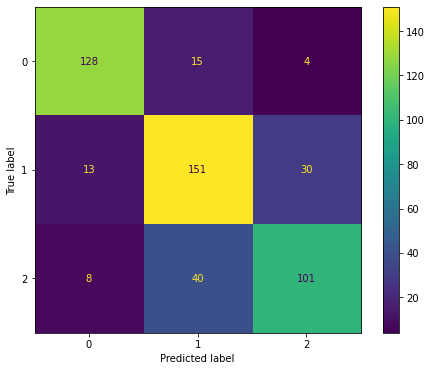

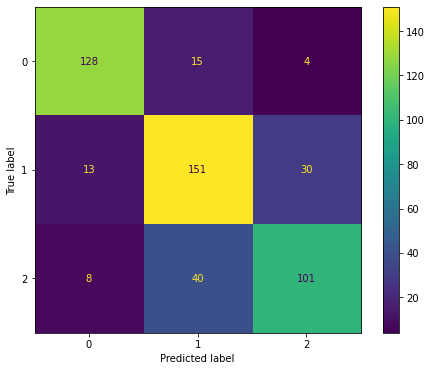

In [26]:
cm = confusion_matrix(labels_test, y_hat)

cm_display = ConfusionMatrixDisplay(cm).plot()

Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

y_pred = gnb.fit(features_train, labels_train).predict(features_test)
print("Number of mislabeled points out of a total %d points : %d" % (features_test.shape[0], (labels_test != y_pred).sum()))

Number of mislabeled points out of a total 490 points : 234
Number of mislabeled points out of a total 490 points : 234


In [28]:
from sklearn.metrics import classification_report
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.32      0.41       147
           1       0.74      0.38      0.50       194
           2       0.44      0.91      0.59       149

    accuracy                           0.52       490
   macro avg       0.59      0.54      0.50       490
weighted avg       0.60      0.52      0.50       490

              precision    recall  f1-score   support

           0       0.59      0.32      0.41       147
           1       0.74      0.38      0.50       194
           2       0.44      0.91      0.59       149

    accuracy                           0.52       490
   macro avg       0.59      0.54      0.50       490
weighted avg       0.60      0.52      0.50       490



We can create confusion matrices to visualize the accuracy of our models, as seen below.

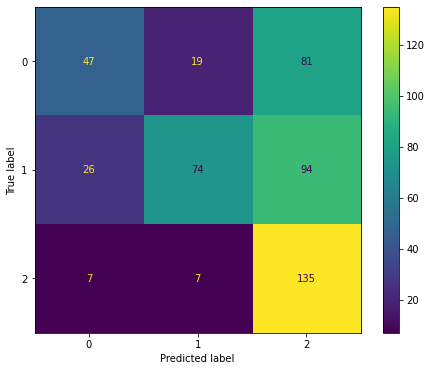

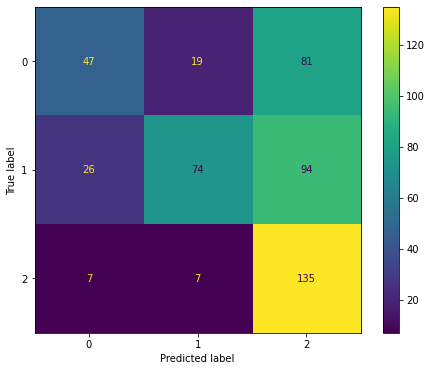

In [29]:
cm = confusion_matrix(labels_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Catbost

#### 5. Final Model Training and Tuning

Given the above exploration, it seems like the random forest model is the most accurate. Given that, we now finetune the hyperparameters and perform k cross fold validation to get our final mode. The grid search takes a while to run (~20 minutes) since it is running over many different combinations of hyperparameters. 

In [31]:
from sklearn.model_selection import GridSearchCV 
import pandas as pd

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

base_estimator = RandomForestClassifier(random_state=0)

grid_model = GridSearchCV(base_estimator, param_grid, cv=5, return_train_score=True).fit(features_train, labels_train)

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
cv_results = pd.DataFrame(grid_model.cv_results_)
cv_results

Final Model Evaluation

In [ ]:
best_grid = grid_model.best_estimator_

y_pred = best_grid.predict(features_test)
cm = confusion_matrix(labels_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
accuracy_score(labels_test, y_pred)

In [ ]:
print(classification_report(labels_test, y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize 
from sklearn.metrics import auc

#Binarize the output
y_test_bin = label_binarize(labels_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

y_score = best_grid.predict_proba(features_test)

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
  plt.plot(fpr[i], tpr[i], color='darkorange', lw=2)
  print('AUC for Class {}: {}'.format(i+1, auc(fpr[i], tpr[i])))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.show()

## source: https://laurenliz22.github.io/roc_curve_multiclass_predictions_random_forest_classifier